In [1]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 6.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=a1a0e37f9b822ac3089e353b4b6be6399bb30626aaf23cb375952b09624803f5
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=7996b44c802e58e4ea7f3d9174147eca3a3da8f784b771e35f255968c8f3e3cd
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras



In [3]:
import io
dataset = pd.read_csv(r'/content/drive/My Drive/age_gender.csv')
#from tensorflow.random import set_seed
import random
np.random.seed(11)
#set_seed(11)
random.seed(11)
!PYTHONHASHSEED=0

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#So in our data we can see that our pixel column.. consist strings.. which we need to make an array of each
#row

def img_arr(x):
    '''
    Function to convert pixel data (string) into array of pixels
    '''
    x=x.reset_index(drop=True)
    n = len(x) #number of rows
    for i in range(n):
        if i==0:
            arr = np.array(x[i].split()).astype(np.int16) #Initializing the array
        else:
            arr = np.append(arr,np.array(x[i].split()).astype(np.int16),axis=0) #Appending data to the array
    return arr.reshape(n,48,48,1) #reshaping the array to 4-dim image pixel array

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


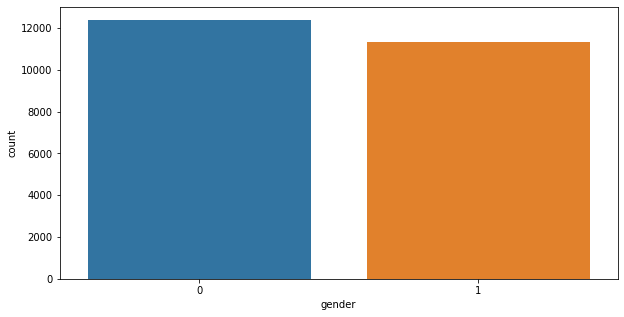

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,5))
sns.countplot('gender', data = dataset)


In [7]:

images = dataset.iloc[:, 4] #X
labels = dataset.iloc[:, 2] #Y

In [8]:

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [9]:
#so now, let's split the data into training, testing 
#so in neural networks, our labels have to be in vectors.. for us to get a better efficiency.. note in neural networks, our data are recorded in 
#ensors.. so we can't just leave it in scalar.. we know a scalar object = 0Dtensor, vector = 1Dtensor

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = 1)
val_images, te_images, val_labels, te_labels = train_test_split(test_images, test_labels, test_size = 0.2, random_state = 1)

In [11]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels = to_categorical(val_labels)

train_images = img_arr(train_images)
test_images = img_arr(test_images)
val_images = img_arr(val_images)
train_images = train_images / 255
test_images = test_images / 255
val_images = val_images / 255


In [12]:
class_names = ['Male', 'Female']

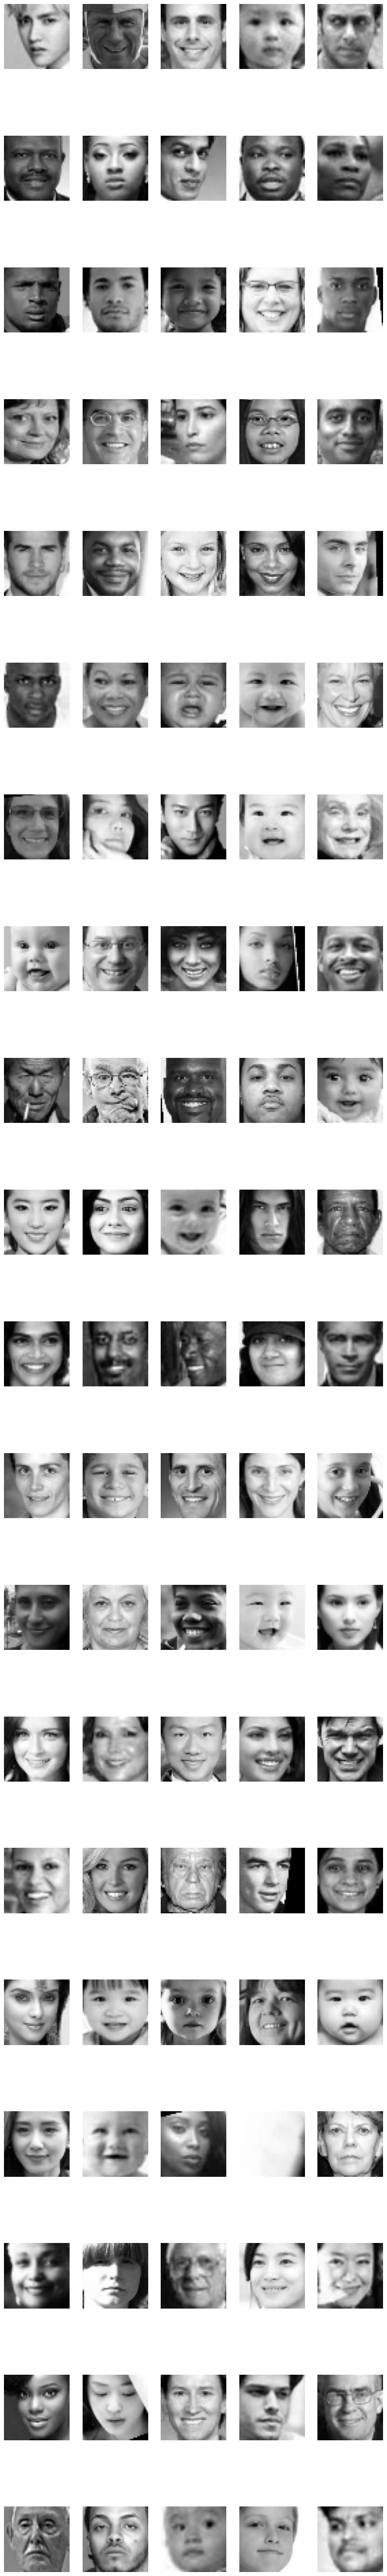

In [13]:
#So let's go on to visualizing our images
rows=20 #rows in subplots
cols=5 #columns in subplots
samp = random.sample(range(train_images.shape[0]),rows*cols) #selecting 100 random samples
image_samples = train_images[samp,:,:,:]
label_samples = train_labels[samp]

fig,ax = plt.subplots(rows,cols,figsize=(12,85))
r = 0
c = 0
for i in range(rows*cols):
    aa = image_samples[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    

    c+=1
    if c == cols:
        c=0
        r += 1
plt.show()


In [14]:
#So let's start with keras tuner.and get a good accuracy to determine the best number of conv layers to be used.. and 
#no. of filters to be used

In [15]:
from keras.models import Sequential

In [16]:

from kerastuner import RandomSearch

In [17]:
from kerastuner.engine.hyperparameters import HyperParameters

In [18]:
def build_model(hp):
  model = Sequential([
                      keras.layers.Conv2D(
                          filters = hp.Int('conv_1_filter' , min_value = 32, max_value = 128, step = 16),
                      kernel_size = hp.Choice('kernel_1', values = [3,5]),
                      activation = 'relu',
                      input_shape = [48, 48, 1]),
                      keras.layers.Conv2D(
                          filters = hp.Int('conv_2_filter', min_value = 32, max_value = 128, step = 16),
                          kernel_size = hp.Choice('kernel_2', values = [3,5]),
                          activation = 'relu'
                      ),
                      keras.layers.Flatten(),
                      keras.layers.Dense(units = hp.Int('Dense_1_Layer', min_value = 32, max_value = 128, step = 16), activation = 'relu'),
                      keras.layers.Dense(units = 2, activation = 'sigmoid')


  ])
  
  model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning rate', values = [0.01, 0.001])), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [19]:
tuner_search = RandomSearch(hypermodel= build_model, objective = 'val_accuracy', max_trials = 5, directory = 'Output', project_name = ' Image Classification')

In [20]:
test_images.shape

(4741, 48, 48, 1)

In [21]:
tuner_search.search(train_images, train_labels, epochs = 3, validation_data = (test_images, test_labels))

Trial 5 Complete [00h 00m 21s]
val_accuracy: 0.8766083121299744

Best val_accuracy So Far: 0.8934823870658875
Total elapsed time: 00h 02m 00s
INFO:tensorflow:Oracle triggered exit


In [22]:
model = tuner_search.get_best_models(num_models = 1)[0]


In [23]:
final_train = np.append(train_images, val_images, axis = 0)
final_labels = np.append(train_labels, val_labels, axis = 0)
#So we concatenate the training images, and train labels in order for us to get more data, in order to get better performance

In [24]:
#model.summary()
train_labels[0]

array([0., 1.], dtype=float32)

In [25]:
model_history = model.fit(final_train, final_labels, epochs = 10, validation_data = (test_images, test_labels), initial_epoch=3)

Epoch 4/10
712/712 [==============================] - 8s 11ms/step - loss: 0.2381 - accuracy: 0.8982 - val_loss: 0.1982 - val_accuracy: 0.9192
Epoch 5/10
712/712 [==============================] - 7s 10ms/step - loss: 0.1920 - accuracy: 0.9224 - val_loss: 0.1639 - val_accuracy: 0.9384
Epoch 6/10
712/712 [==============================] - 7s 10ms/step - loss: 0.1449 - accuracy: 0.9412 - val_loss: 0.1458 - val_accuracy: 0.9441
Epoch 7/10
712/712 [==============================] - 7s 10ms/step - loss: 0.1086 - accuracy: 0.9600 - val_loss: 0.1112 - val_accuracy: 0.9601
Epoch 8/10
712/712 [==============================] - 7s 10ms/step - loss: 0.0787 - accuracy: 0.9716 - val_loss: 0.1043 - val_accuracy: 0.9673
Epoch 9/10
712/712 [==============================] - 7s 10ms/step - loss: 0.0558 - accuracy: 0.9827 - val_loss: 0.0948 - val_accuracy: 0.9747
Epoch 10/10
712/712 [==============================] - 7s 10ms/step - loss: 0.0412 - accuracy: 0.9879 - val_loss: 0.1076 - val_accuracy: 0.973

In [26]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [27]:
predictions = model.predict(test_images)

In [28]:
predictions

array([[6.4377764e-07, 9.9999952e-01],
       [8.4503835e-01, 1.5151344e-01],
       [9.9931037e-01, 6.4142101e-04],
       ...,
       [9.9999940e-01, 5.7632559e-07],
       [2.2534974e-01, 7.2794092e-01],
       [9.7940409e-01, 1.2864074e-02]], dtype=float32)

In [29]:
predictions = np.round(predictions) #So everything that are < 0.5, wil be considered 0... 

In [30]:
predictions = predictions.astype('int32')

In [31]:
roc_auc_score(test_labels, predictions)

0.9729532789672224

In [32]:
accuracy_score(test_labels, predictions)

0.9704703649019194

In [33]:
classification_report(test_labels, predictions)
#Pretty good accuracy.. 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.97      2487\n           1       0.97      0.98      0.97      2254\n\n   micro avg       0.97      0.97      0.97      4741\n   macro avg       0.97      0.97      0.97      4741\nweighted avg       0.97      0.97      0.97      4741\n samples avg       0.97      0.97      0.97      4741\n'

In [34]:
model.save('Gender Classification.h5')

In [35]:
predictions = np.argmax(predictions, axis =-1)
test_labels = np.argmax(test_labels, axis = -1)
error_index = (test_labels != predictions) #finding error indices
test_images_error = test_images[error_index]
test_labels_error = test_labels[error_index]
predictions_error = predictions[error_index]

In [36]:
test_images[0]

array([[[0.13333333],
        [0.16470588],
        [0.17647059],
        ...,
        [0.23529412],
        [0.10588235],
        [0.09803922]],

       [[0.11764706],
        [0.18431373],
        [0.18039216],
        ...,
        [0.30588235],
        [0.10196078],
        [0.06666667]],

       [[0.11372549],
        [0.2       ],
        [0.13333333],
        ...,
        [0.43137255],
        [0.19607843],
        [0.08235294]],

       ...,

       [[0.14509804],
        [0.09411765],
        [0.09803922],
        ...,
        [0.54509804],
        [0.48235294],
        [0.45490196]],

       [[0.12156863],
        [0.11372549],
        [0.1254902 ],
        ...,
        [0.64705882],
        [0.44313725],
        [0.45490196]],

       [[0.10980392],
        [0.1254902 ],
        [0.12156863],
        ...,
        [0.82352941],
        [0.50196078],
        [0.45882353]]])

In [37]:
#Error Analysis
#Analyzing the errors visually may help in tuning image augmentation parameters as well as the model architecture. 
#It also gives an idea of how the model may perform in the future and determine if the model matches human level performance.
#len(predictions)
test_labels

array([1, 1, 0, ..., 0, 1, 0])

In [38]:
cols = 3
rows = int(np.floor(sum(error_index) / 3)) #

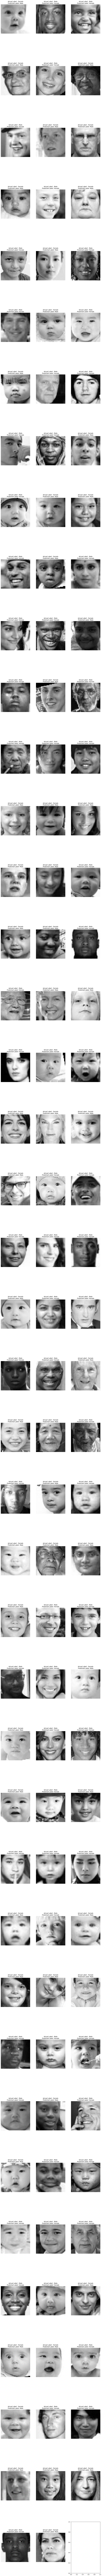

In [39]:
#ALL THESE ARE REGARDING ERRORS

x_samp = test_images_error
y_samp = test_labels_error 

fig, ax = plt.subplots(rows, cols, figsize = (15, 400))
r = 0
c = 0
for i in range((rows * cols)-1):
  aa = x_samp[i].reshape(48,48)
  ax[r,c].axis('off')
  ax[r,c].imshow(aa, cmap ='gray')
  actual_lab = 'Female' if y_samp[i] == 1 else 'Male'
  pred_lab = 'Female' if predictions_error[i] == 1 else 'Male'
  ax[r,c].set_title(f'Actual Label : {actual_lab}\nPredicted Label: {pred_lab}')
  c+=1
  if c == cols:
    c = 0
    r += 1
plt.show()




In [40]:
error_index

array([False,  True, False, ..., False, False, False])

In [41]:
dataset_1 = pd.DataFrame({'S/N': np.array(range(1, len(y_samp) + 1)), 'y_samp': y_samp})

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


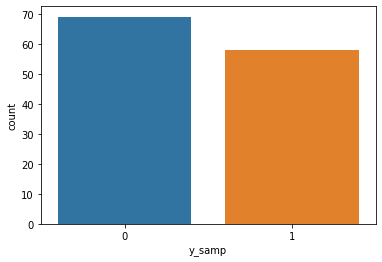

In [42]:
sns.countplot('y_samp', data = dataset_1)

In [43]:
#so we can infer from this plot,that there are more of male than female which were predicted wrongly by our model

#We can update our notebook furtherby adding data augmentation which is a very good method of improving the accuracy score

#Let's save and deploy our model

In [44]:

import matplotlib.pyplot as plt
import tempfile
import os, re
import json
import tensorflow as tf
tf.__version__

'2.4.0'

In [45]:
Model_Directory = tempfile.gettempdir()   #Get a temp storage directory where i'll save the model

In [46]:
Model_Directory

'/tmp'

In [47]:
version = 1             #Specify a version number for your model

In [48]:
#So now let's join our temporary directory with the model version
export_path = os.path.join(Model_Directory, str(version))
print(f"Export Path : {export_path}")

Export Path : /tmp/1


In [49]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: /tmp/1/assets


In [50]:
!ls -l {export_path}

total 128
drwxr-xr-x 2 root root   4096 Jan 17 23:08 assets
-rw-r--r-- 1 root root 121320 Jan 17 23:08 saved_model.pb
drwxr-xr-x 2 root root   4096 Jan 17 23:08 variables


Let's explore our saved model
Show us our metagraphs , signatures, 
A metagraph is like a graph which is used to show the ,the dataflow graph, plus the assets, variables, signatures.
signatures are the sets of inputs and outputs from a graph

In [51]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 48, 48, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0117 23:08:58.810553 140385439471488 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pyth

In [52]:
#Let's serve our model
#Let's first download our tensorflow serving package
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  21962      0 --:--:-- --:--:-- --:--:-- 21962
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/r

In [53]:
#Install Tensorflow Serving
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 52 not upgraded.
Need to get 223 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.4.0 [223 MB]
Fetched 223 MB in 3s (84.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.4.0_all.deb ...
Unpacking tensorflow-model-server (2.4.0) ...
Setting up tensorflow-model-server (2.4.0) ...


In [54]:
#Tensorflow Serving 
#This is where we start loading tensorflow serving.. and load our model,
#WE start making inference requests using REST
os.environ["Model_Directory"] = Model_Directory

In [55]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=Gender_Classification \
  --model_base_path="${Model_Directory}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [56]:
!tail server.log

2021-01-17 23:09:15.786948: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
2021-01-17 23:09:15.786980: I tensorflow_serving/model_servers/server_core.cc:587]  (Re-)adding model: Gender_Classification
2021-01-17 23:09:15.788637: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: Gender_Classification version: 1}
2021-01-17 23:09:15.788663: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: Gender_Classification version: 1}
2021-01-17 23:09:15.788701: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: Gender_Classification version: 1}
2021-01-17 23:09:15.788744: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:32] Reading SavedModel from: /tmp/1
2021-01-17 23:09:15.791010: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:55] Reading meta graph with tags { serve }
2021-01-17 23:09:15.791045: I external/org_tenso

In [57]:
#Make a request to my model in tensorflow serving

In [58]:
#Let's create a json object for a batch of four interface requests and let's see how our model recognizes things

In [59]:
data= json.dumps({"signature_name": "serving_default", "instances": test_images[:3].tolist()})

In [60]:
data

'{"signature_name": "serving_default", "instances": [[[[0.13333333333333333], [0.16470588235294117], [0.17647058823529413], [0.14901960784313725], [0.1568627450980392], [0.11372549019607843], [0.16862745098039217], [0.1843137254901961], [0.12941176470588237], [0.10980392156862745], [0.11372549019607843], [0.09411764705882353], [0.10196078431372549], [0.11372549019607843], [0.12549019607843137], [0.4392156862745098], [0.6352941176470588], [0.6980392156862745], [0.7215686274509804], [0.7215686274509804], [0.7215686274509804], [0.7215686274509804], [0.7333333333333333], [0.7333333333333333], [0.7333333333333333], [0.7529411764705882], [0.7647058823529411], [0.7803921568627451], [0.788235294117647], [0.796078431372549], [0.796078431372549], [0.807843137254902], [0.796078431372549], [0.788235294117647], [0.7764705882352941], [0.7725490196078432], [0.7647058823529411], [0.7568627450980392], [0.7529411764705882], [0.7372549019607844], [0.7294117647058823], [0.6980392156862745], [0.67843137254

In [61]:
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 3333], [0.3568627450980392], [0.596078431372549]]]]}


MAKE REST REQUESTS


Newest Version Of our servable
we'll send a predict request as a POST to our server's REST endpoint and pass it three examples .. we'll need the latest version of our servable by not specifying a particular version . 

In [62]:
!pip install -q requests

In [63]:
test_labels

array([1, 1, 0, ..., 0, 1, 0])

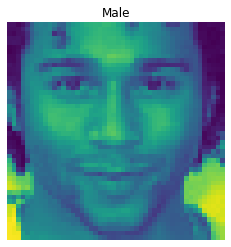

In [64]:
#Let's get a sample of our model
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(48,48))
  plt.axis("off")
  plt.title(f'{title}')
  
import random
rando = random.randint(0, len(test_images)-1)
show(rando, 'Female' if test_labels[rando]==1 else 'Male')

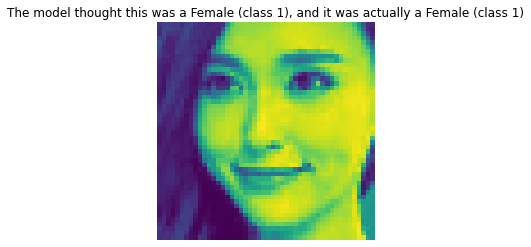

In [65]:
import requests 
import subprocess
headers = {"content-type": "application/json"}
json_response = requests.post("http://localhost:8501/v1/models/Gender_Classification:predict", data = data , headers = headers)
prediction = json.loads(json_response.text)['predictions'] 
show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(prediction[0])], np.argmax(prediction[0]), class_names[test_labels[0]], test_labels[0]))

So now let's specify a particular model of our servable since we only have one, let's select version 1 , we'll also look at the three results.

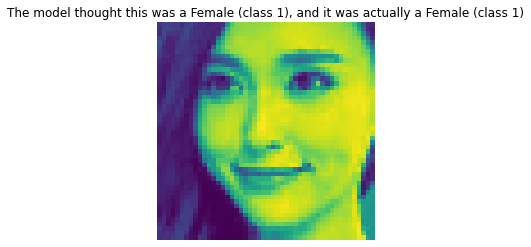

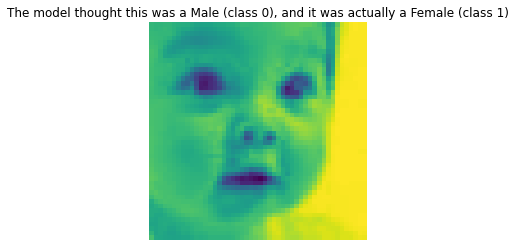

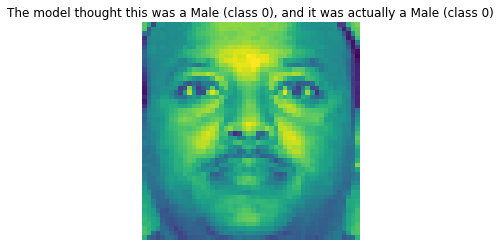

In [66]:
headers = {"content-type": "application/json"}
json_response = requests.post("http://localhost:8501/v1/models/Gender_Classification/versions/1:predict", data = data , headers = headers)
prediction = json.loads(json_response.text)['predictions'] 
for i in range(0, 3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(prediction[i])], np.argmax(prediction[i]), class_names[test_labels[i]], test_labels[i]))

In [67]:
#I guess the model didn't classify the Baby's image correctly because,even based on real-life , it's even hard to tell whether a baby is a male/female.

In [75]:
import shutil
shutil.make_archive('/tmp/1', 'zip', '/tmp/1')

'/tmp/1.zip'